In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

import nltk

from gensim.models import word2vec
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.svm import LinearSVC
from sklearn.metrics import mean_absolute_error
from joblib import dump, load

In [ ]:
train_imdb = pd.read_csv('/content/drive/MyDrive/imdb_train.csv', index_col=0)
test_imdb = pd.read_csv('/content/drive/MyDrive/imdb_test.csv', index_col=0)

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
def remove_html_tags(text):
    pattern = re.compile('<.*?>')
    return pattern.sub('', text)


def remove_url(text):
    pattern=re.compile(r'https?://\S+|www\.\S+')
    return pattern.sub(r'',text)


def short_conv(text):
    new_text = []
    for w in text.split():
        if w.upper() in chat_word:
            new_text.append(chat_word[w.upper()])
        else:
            new_text.append(w)
    return " ".join(new_text)


chat_word = {
    'AFAIK': 'As Far As I Know',
    'AFK': 'Away From Keyboard',
    'ASAP': 'As Soon As Possible',
    'ATK': 'At The Keyboard',
    'ATM': 'At The Moment',
    'A3': 'Anytime, Anywhere, Anyplace',
    'BAK': 'Back At Keyboard',
    'BBL': 'Be Back Later',
    'BBS': 'Be Back Soon',
    'BFN': 'Bye For Now',
    'B4N': 'Bye For Now',
    'BRB': 'Be Right Back',
    'BRT': 'Be Right There',
    'BTW': 'By The Way',
    'B4': 'Before',
    'CU': 'See You',
    'CUL8R': 'See You Later',
    'CYA': 'See You',
    'FAQ': 'Frequently Asked Questions',
    'FC': 'Fingers Crossed',
    'FWIW': "For What It's Worth",
    'FYI': 'For Your Information',
    'GAL': 'Get A Life',
    'GG': 'Good Game',
    'GN': 'Good Night',
    'GMTA': 'Great Minds Think Alike',
    'GR8': 'Great!',
    'G9': 'Genius',
    'IC': 'I See',
    'ICQ': 'I Seek you (also a chat program)',
    'ILU': 'ILU: I Love You',
    'IMHO': 'In My Honest/Humble Opinion',
    'IMO': 'In My Opinion',
    'IOW': 'In Other Words',
    'IRL': 'In Real Life',
    'KISS': 'Keep It Simple, Stupid',
    'LDR': 'Long Distance Relationship',
    'LMAO': 'Laugh My A.. Off',
    'LOL': 'Laughing Out Loud',
    'LTNS': 'Long Time No See',
    'L8R': 'Later',
    'MTE': 'My Thoughts Exactly',
    'M8': 'Mate',
    'NRN': 'No Reply Necessary',
    'OIC': 'Oh I See',
    'PITA': 'Pain In The A..',
    'PRT': 'Party',
    'PRW': 'Parents Are Watching',
    'QPSA?': 'Que Pasa?',
    'ROFL': 'Rolling On The Floor Laughing',
    'ROFLOL': 'Rolling On The Floor Laughing Out Loud',
    'ROTFLMAO': 'Rolling On The Floor Laughing My A.. Off',
    'SK8': 'Skate',
    'STATS': 'Your sex and age',
    'ASL': 'Age, Sex, Location',
    'THX': 'Thank You',
    'TTFN': 'Ta-Ta For Now!',
    'TTYL': 'Talk To You Later',
    'U': 'You',
    'U2': 'You Too',
    'U4E': 'Yours For Ever',
    'WB': 'Welcome Back',
    'WTF': 'What The F...',
    'WTG': 'Way To Go!',
    'WUF': 'Where Are You From?',
    'W8': 'Wait...',
    '7K': 'Sick:-D Laugher',
    'TFW': 'That feeling when',
    'MFW': 'My face when',
    'MRW': 'My reaction when',
    'IFYP': 'I feel your pain',
    'TNTL': 'Trying not to laugh',
    'JK': 'Just kidding',
    'IDC': "I don't care",
    'ILY': 'I love you',
    'IMU': 'I miss you',
    'ADIH': 'Another day in hell',
    'ZZZ': 'Sleeping, bored, tired',
    'WYWH': 'Wish you were here',
    'TIME': 'Tears in my eyes',
    'BAE': 'Before anyone else',
    'FIMH': 'Forever in my heart',
    'BSAAW': 'Big smile and a wink',
    'BWL': 'Bursting with laughter',
    'BFF': 'Best friends forever',
    'CSL': "Can't stop laughing"
}

In [ ]:
stop_words = set(stopwords.words('english'))

def preprocess(text):
    text = text.lower() # приводим к нижнему регистру
    text = remove_html_tags(text)
    text = remove_url(text)
    text = ''.join([word for word in text if word not in string.punctuation]) # убираем пунктуацию
    text = short_conv(text)
    tokens = word_tokenize(text) # токенизируем
    tokens = [word for word in tokens if word not in stop_words] # убираем стоп-слова
    return ' '.join(tokens)

In [ ]:
%%time

train_imdb['review'] = train_imdb['review'].apply(preprocess)
test_imdb['review'] = test_imdb['review'].apply(preprocess)

CPU times: user 1min 1s, sys: 186 ms, total: 1min 2s
Wall time: 1min 3s


In [ ]:
sentences_train = [text.split() for text in train_imdb['review'].values]
sentences_test = [text.split() for text in test_imdb['review'].values]

In [ ]:
%%time
vector_size = 128
w2v_model = word2vec.Word2Vec(sentences=sentences_train, vector_size=vector_size, min_count=5, window=5)

CPU times: user 54.3 s, sys: 290 ms, total: 54.6 s
Wall time: 34.9 s


In [ ]:
w2v_model.wv.most_similar(positive=["actor"])

[('actress', 0.8698813915252686),
 ('role', 0.7916025519371033),
 ('comedian', 0.7595325708389282),
 ('roles', 0.7154468894004822),
 ('casting', 0.7118959426879883),
 ('pacino', 0.6871468424797058),
 ('performance', 0.6840059161186218),
 ('ohearn', 0.6710762977600098),
 ('spacey', 0.6682037711143494),
 ('brosnan', 0.6600148677825928)]

In [ ]:
def vectorize(sentences):
    X = []
    for sentence in sentences:
        sentence_vector = []
        for word in sentence:
            try:
                vector = w2v_model.wv.get_vector(word)
                sentence_vector.append(vector)
            except KeyError:
                # если слово не встретилось при обучениии модели word2vec
                pass
        if len(sentence_vector) > 0:
            sentence_vector = np.array(sentence_vector).mean(axis=0)
        else:
            # вернем нулевой вектор для отзыва, в котором ни одно слово не встречалось в обучении
            sentence_vector = np.zeros(vector_size)
        X.append(sentence_vector)
    return np.array(X)

In [ ]:
W2V_train = vectorize(sentences_train)
W2V_test = vectorize(sentences_test)

In [ ]:
y_train = train_imdb['rating'].to_numpy()

In [ ]:
smote = SMOTE(random_state=42)

W2V_train_upsampled, y_train_upsampled = smote.fit_resample(W2V_train, y_train)

In [ ]:
clf = LinearSVC()

clf.fit(W2V_train_upsampled, y_train_upsampled)

LinearSVC()

In [ ]:
y_pred = clf.predict(W2V_test)
y_pred

array([ 7,  1,  1, ...,  8, 10, 10])

In [ ]:
mean_absolute_error(test_imdb['rating'].to_numpy(), y_pred)

1.78828

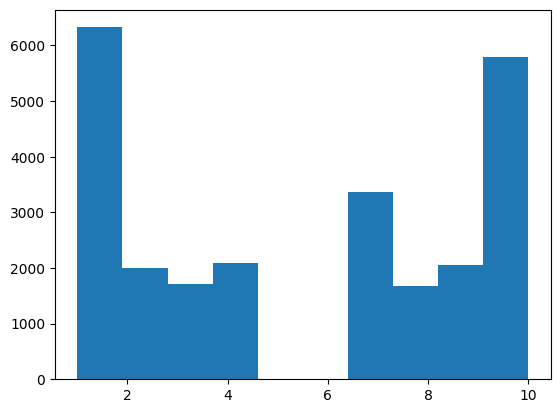

In [ ]:
plt.hist(y_pred);

In [ ]:
my_review = 'good'
my_review = vectorize(np.array([preprocess(my_review).split()]))

In [ ]:
clf.predict(my_review)

array([7])

In [ ]:
dump(clf, 'ratitng_model.joblib')

['ratitng_model.joblib']

In [ ]:
clf_download = load('ratitng_model.joblib')
clf_download.predict(my_review)

array([7])

In [ ]:
w2v_model.save('embedding.model')